# Skewness to identify stage of Corona

Here I am going to explain how evaluating skewness can help quickly identifing the stage of the pandemic in a region. It's a simple trick but can faithfully identify all the regions where the cases of Corona has already reached its peak. Let's begin then.

I will just combine the Province_State column with the Country column to make a single column Location. By doing so we can observe the case in a regionwise basis.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv')
df['Date'] = pd.to_datetime(df['Date'])

df['Province_State'] = '_'+df['Province_State']
df['Province_State'].fillna("",inplace=True)
df['Location'] = df['Country_Region']+df['Province_State']

I won't be considering the locations where the Confirmed Cases is very less, as the graph mostly resembles a step function which is not ideal for the calculation.

In [ ]:
locations = []
for loc,gdf in df.groupby('Location'):
    
    if gdf.ConfirmedCases.max()>200:
        locations.append(loc)
        
df = df[df.Location.isin(locations)]

# Sigmoid Curve 

As we know the growth of a pandemic follows a sigmoid curve. If we plot the derivative of the curve it forms a bell curve. For a complete sigmoid curve the derivative is a perfect gaussian curve.

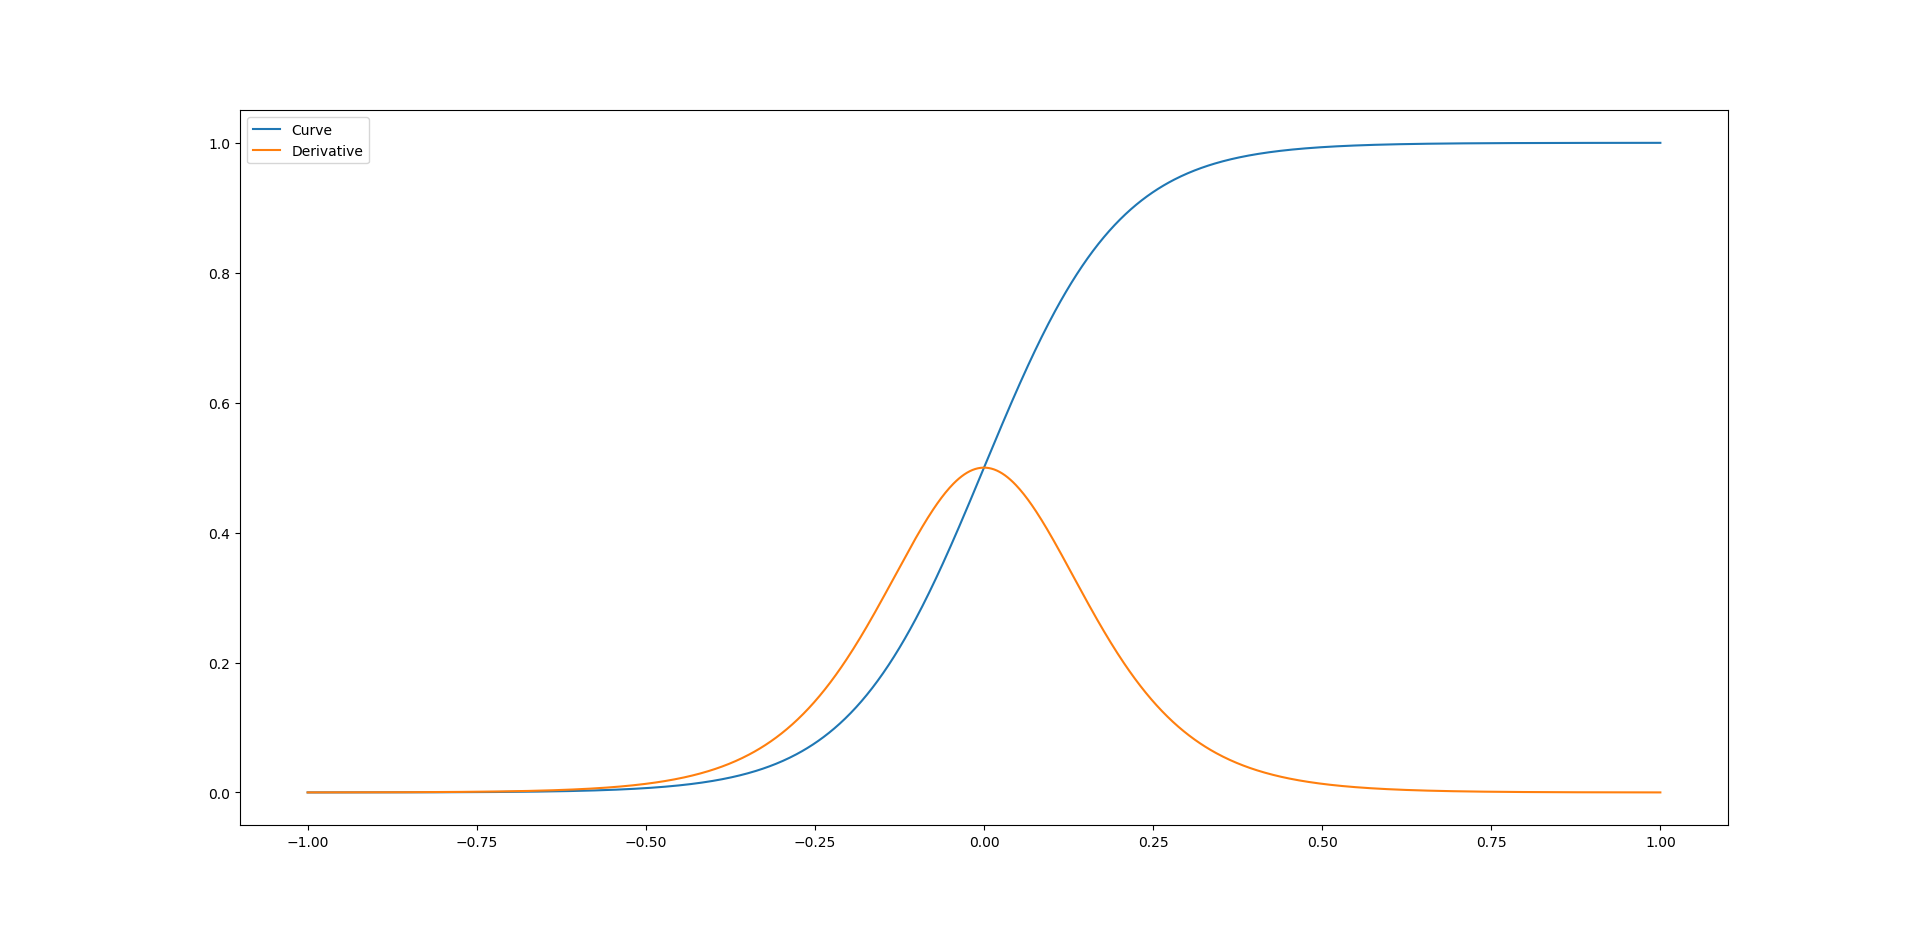

But, if the graph is incomplete, i.e. the curve is still in its exponential or linear phase then the derivative will also be an incomplete bell curve.
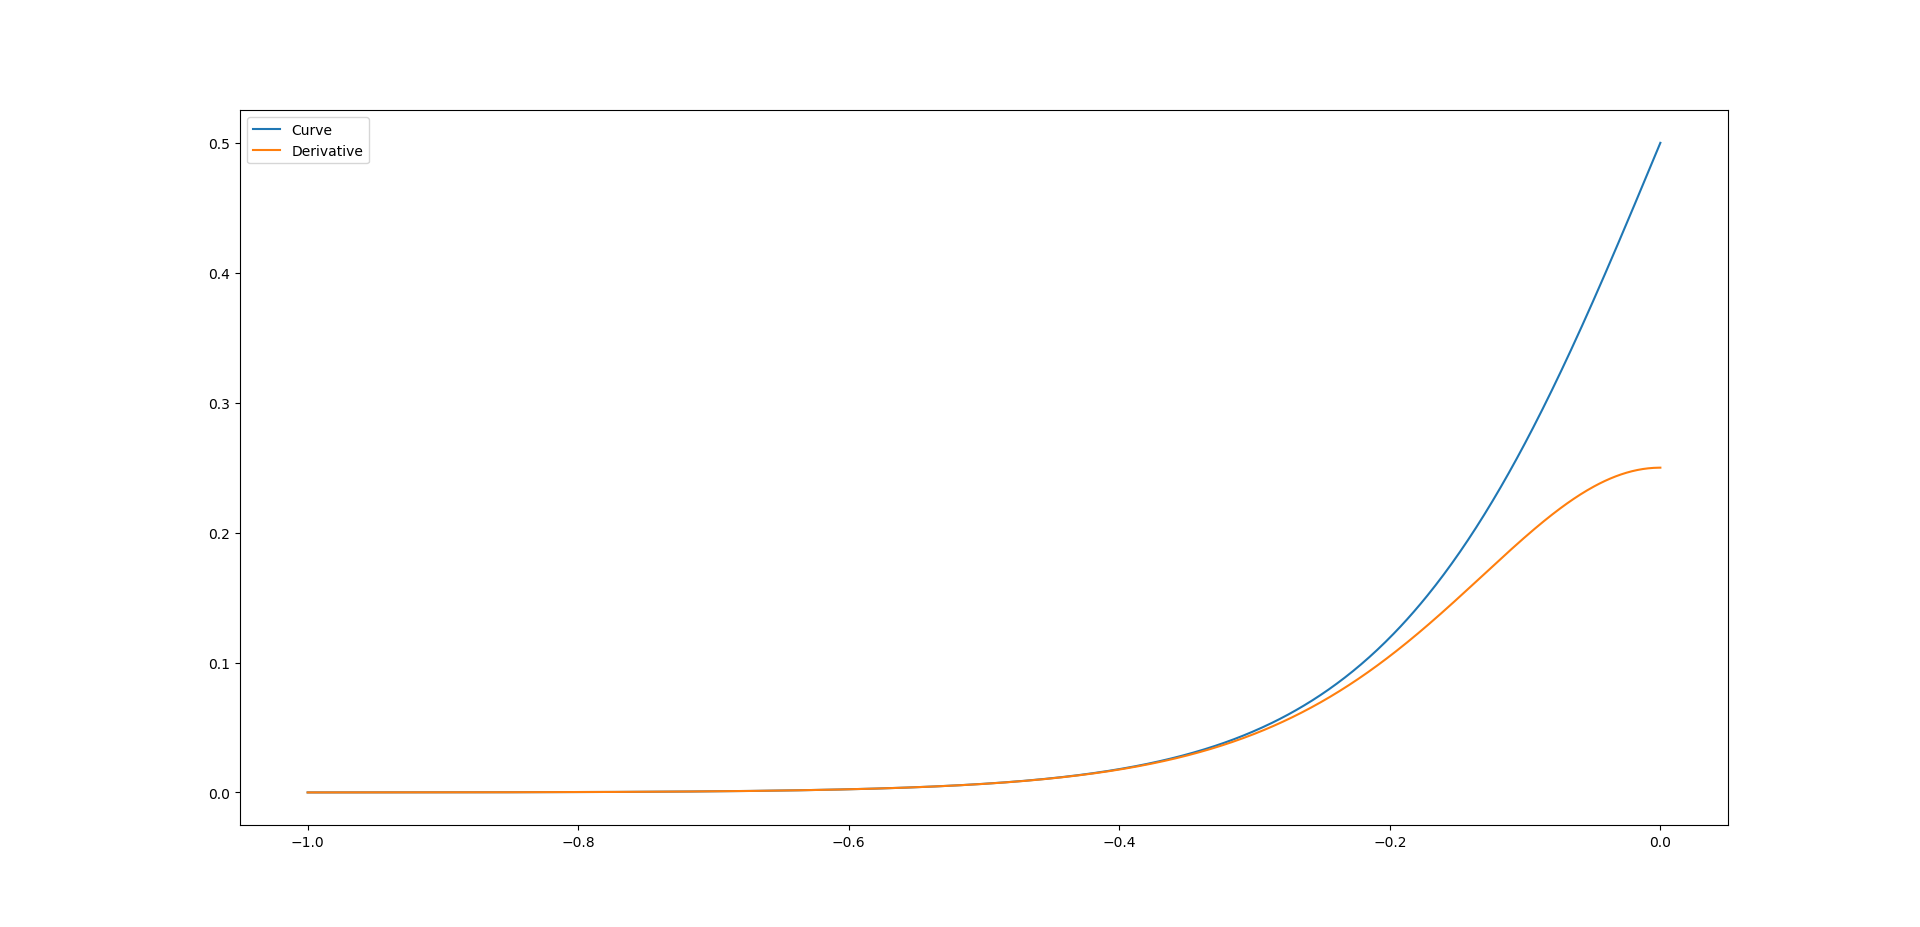

We can observe this pattern in the data by plotting graph for the regions where Covid has reached its peak vs where it is still in its initial stages. 

# Analysing the data

In [ ]:
def plotCases(df,loc):
    gdf = df.loc[df.Location==loc]
    plt.scatter(range(len(gdf.ConfirmedCases)),gdf.ConfirmedCases)

def plotDifference(df,loc):
    '''plots new cases on each day'''
    gdf = df.loc[df.Location==loc]
    y = list(gdf.ConfirmedCases)
    y = [y[i+1]-y[i] for i in range(len(y)-1)]
    
    plt.plot(range(len(y)),y)

In [ ]:
plotCases(df,'Diamond Princess')

In [ ]:
plotDifference(df,'Diamond Princess')

In [ ]:
plotCases(df,'Belarus')

In [ ]:
plotDifference(df,'Belarus')

If we find the skewness of the difference curve then we can very accurately determine the stage of Corona in each region. A graph which is right-skewed is already past it's maximum difference phase. And a left-skewed graph will indicate that the cases are still in exponential phase for the country.

We can treat the difference i.e. new cases each day as the frequency of that day to treat this graph as a distribution, so that we can calculate the skewness. Here is the code,

In [ ]:
def getSkewnessDict(df):
    
    skewDict = {}
    
    for loc,gdf in df.groupby('Location'):
        
        y = list(gdf['ConfirmedCases'])
        y = [y[i+1]-y[i]+1 for i in range(len(y)-1)]
        
        meanY = np.average(range(1,len(y)+1),weights=y)
        var = 0
        sumY = sum(y)
        for i,yd in enumerate(y,start=1):
            var += (yd*((i-meanY)**2))/sumY
        std = np.sqrt(var)
        skewness = sum((yd*(i-meanY)**3)/(sumY*std**3) for i,yd in enumerate(y,start=1))
        
        skewDict[loc] = skewness
        
    return skewDict

In [ ]:
skDict = getSkewnessDict(df)
skDf = pd.DataFrame({"Location":list(sorted(skDict,key=skDict.get,reverse=True))
                     ,"Skewness":list(sorted(skDict.values(),reverse=True))})
skDf

In [ ]:
(skDf.Skewness>0).sum()

So currently out of the 196 locations we took into consideration, 20 of them have already reached their peak. The rest are yet to stablize.

# Can we do more?

If we check the countries where skewness value is negetive yet very close to zero. Examples of such countries are Italy,Spain,Germany. I am plottting some of them below.

In [ ]:
plotCases(df,'Italy')

In [ ]:
plotCases(df,'Spain')

In [ ]:
plotCases(df,'Germany')

Although the graph is yet to be leveled here, we can very well notice that the growth is slowing down here. The skewness value can very well be an indicator for how far the country is from controlling the disease.

# Conclusion

The number of regions where Covid19 has spead is very high indeed. It's hard to plot and observe all the regions where the pandemic has speard. The method explained above is a quick way to figure our the stage of Corona in a region. Thank you for reading till the end. This is my first attempt at writing a public notebook. If you have any suggestions for improvement please leave them in comments. If you like it please leave an upvote.